In [133]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""


df = pd.read_sql(query, conn)


Figure out delta


In [134]:
howManyPeopleQuery = """
SELECT COUNT(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and  gender = 'M'
ORDER by gender
;
"""

maxQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20
ORDER by gender
;
"""

howManyPeopleDF = pd.read_sql(howManyPeopleQuery, conn)
maxDF = pd.read_sql(maxQuery, conn)
people = int(howManyPeopleDF.to_string(index=False, header=False))
maxages = int(maxDF.to_string(index=False, header=False))

delta = people / maxages
delta




72.4

In [135]:
import snsql
from snsql import Privacy

metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'patient': {
                    'name': 'patient',
                    'type': 'string'
                },
                'age': {
                    'name': 'age',
                    'type': 'int',
                    'lower': '0',
                    'upper': '100'
                },
                'gender': {
                    'name': 'gender',
                    'type': 'string'
                }
            }
        }
    }
}


privacy = Privacy(epsilon=0.1, delta=1)
reader = snsql.from_connection(df, privacy=privacy, metadata=metadata)

r = reader.execute('SELECT gender, AVG(age) as age FROM MyTable GROUP BY gender')

C:\Users\krist\anaconda3\lib\site-packages\snsql\sql\private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(


In [136]:
r

[['gender', 'age'], ['F', 60.38783160322953], ['M', 56.958736187845304]]

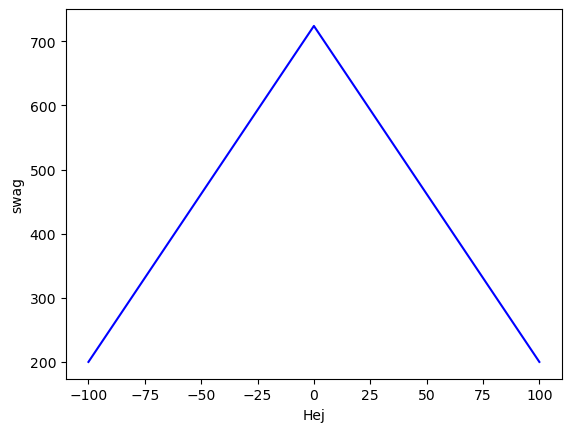

In [204]:
import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt
scale = delta / 0.1

plt.plot([-100,0,100],[200, scale,200], color='b')
plt.xlabel("Hej")
plt.ylabel("swag")
plt.show()